In [1]:
import xarray
import pygmt
import pandas
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ds = xarray.open_dataset("../data/MIROC_outputs/ctrl_MIROC-COSP2.nc")

In [3]:
%%capture

vname='dplrw_T'
var=ds[vname]

In [4]:
#grids

lat=ds["latitude"].values
lon=ds["longitude"].values

temp=ds["lvtemp_grid"].values
zgrd=ds["lvdBZe_grid"].values
vgrd=ds["lvdplr_grid"].values

In [5]:
dx = vgrd[1] - vgrd[0]
x_edge = np.concatenate([
        [vgrd[0] - dx/2],
        vgrd + dx/2
        ])

dy = temp[1] - temp[0]
y_edge = np.concatenate([
         [temp[0] - dy/2],
         temp + dy/2
         ])

In [6]:
south=-20.
north=20.
east=360.
west=0.

regime=0

In [7]:
# location mask
lon_mask = (lon >= west) & (lon <= east)
lat_mask = (lat >= south)&(lat <= north)

mask = lon_mask & lat_mask

index = np.where(mask)[0]

In [8]:
sel = var.isel(regimeID=regime).isel(loc=index)
smpl = sel.sum(dim='loc', skipna=True).values
window = 0.2

In [9]:
nrm = window * smpl.sum(axis=1, keepdims=True)
nrm = np.broadcast_to(nrm,smpl.shape)

zero_check = (nrm < window)
cfed = np.zeros_like(smpl)

cfed[~zero_check] = smpl[~zero_check]/nrm[~zero_check]
cfed[zero_check] = np.nan

In [10]:
%%capture
plt.figure(figsize=(8, 6))

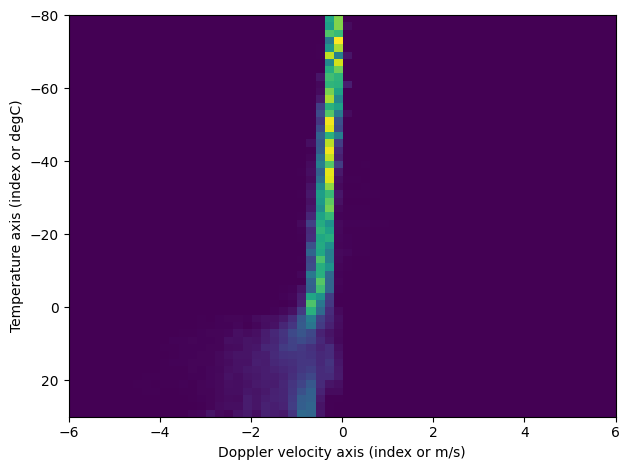

In [11]:
extent = [x_edge[0], x_edge[-1], y_edge[-1], y_edge[0]]

im = plt.imshow(cfed,
                extent=extent,
                interpolation='nearest',
                origin='upper',
                aspect='auto')

plt.xlabel("Doppler velocity axis (index or m/s)")
plt.ylabel("Temperature axis (index or degC)")

plt.tight_layout()
plt.show()